In [55]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge, SGDRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score, KFold
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("seaborn")
import statsmodels.formula.api as smf

from scipy import stats

In [50]:
my_seed = 12345

# Misconception 1: OLS same as linreg

In [32]:
number_of_obs = 50
np.random.seed(my_seed)
X = np.random.uniform(0, 100, number_of_obs)
residuals = np.random.normal(0, 30, number_of_obs)
y = X + residuals + 10
X = X.reshape(-1,1)

In [33]:
lr = LinearRegression()
y_pred_lr = lr.fit(X,y).predict(X)

In [34]:
# this does not seem to work
sgd = SGDRegressor(loss = 'epsilon_insensitive', epsilon = 0, penalty = 'l2')
y_pred_sgd = sgd.fit(X,y).predict(X)

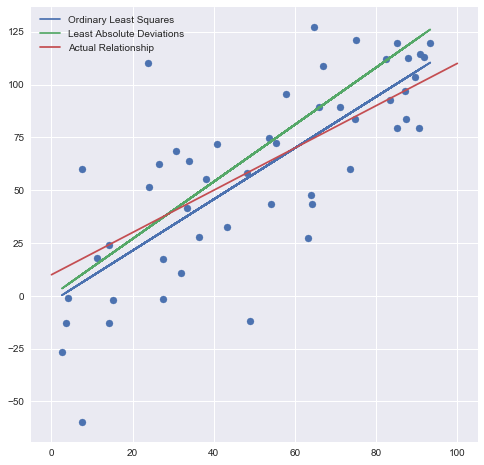

In [35]:
plt.figure(figsize  = (8,8))
plt.scatter(X[:,0], y)
plt.plot(X, y_pred_lr, label = 'Ordinary Least Squares')
plt.plot(X, y_pred_sgd, label = 'Least Absolute Deviations')
plt.plot([0,100],[10,110], label = 'Actual Relationship')

plt.legend()

plt.savefig('charts/OLS_vs_LAD.png', bbox_inches='tight')

plt.show()

to get the least absolute deviation, I used: https://stats.stackexchange.com/questions/376643/is-there-any-library-for-least-absolute-deviation-lad-regression-with-regulari

# Misconception 2 - Multicollinearity

## High but not Perfect Multicollinearity

In [2]:
# generate two correlated uniform, following guidelines here: 
# https://twiecki.io/blog/2018/05/03/copulas/

In [85]:
number_of_obs = 1000
np.random.seed(my_seed)

mvnorm = stats.multivariate_normal(mean=[0, 0], cov=[[1., 0.9], 
                                                     [0.9, 1.]])
X_norm = mvnorm.rvs(number_of_obs)
X = stats.norm().cdf(X_norm)
X1 = X[:,0]
X2 = X[:,1]
np.corrcoef(X1,X2)

array([[1.        , 0.89713787],
       [0.89713787, 1.        ]])

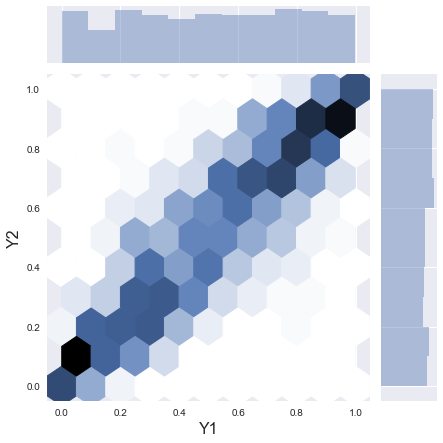

In [86]:
h = sns.jointplot(X[:, 0], X[:, 1], kind='hex', stat_func=None)
h.set_axis_labels('Y1', 'Y2', fontsize=16);

In [93]:
residuals = stats.norm(loc = 0, scale = 1).rvs(number_of_obs)
y = 30 * X1 - 10 * X2 + residuals

In [94]:
lr = LinearRegression()
lr.fit(X,y)
lr.coef_

array([29.61351651, -9.78704263])

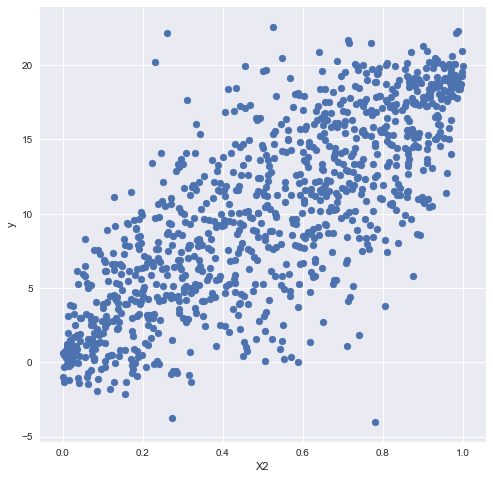

In [96]:
plt.figure(figsize  = (8,8))
plt.scatter(X2, y)
plt.xlabel('X2')
plt.ylabel('y')
plt.savefig('charts/multicoll_chart.png', bbox_inches='tight')
plt.show()

## Numpy Method

In [134]:
obs_no = 100
np.random.seed(my_seed)
X1 = np.random.uniform(0,100,obs_no)
X2 = np.random.uniform(0,100,obs_no)
intercept = np.ones((obs_no))
X = np.vstack((intercept, X1, X2)).T
residuals = np.random.normal(0,10,obs_no)
y = 10 + 2 * X1 + 3 * X2 + residuals

In [135]:
Xt = X.T
XtX = Xt.dot(X)
XtX_inv = np.linalg.inv(XtX)
Xty = Xt.dot(y)
coeff = XtX_inv.dot(Xty)
y_pred = X.dot(coeff)

In [136]:
coeff

array([12.54633457,  1.96763769,  2.97562801])

## Perfect Multicollinearity

In [4]:
obs_no = 100
np.random.seed(my_seed)
X1 = np.random.uniform(0,100,obs_no)
X2 = 2 * X1
residuals = np.random.normal(0,1,obs_no)
y =  X1 + X2 + residuals

In [5]:
X = np.vstack((X1, X2)).T

In [6]:
lr = LinearRegression()
lr.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [7]:
lr.coef_

array([0.60023761, 1.20047523])

In [8]:
lr.coef_[1] * 2 + lr.coef_[0]

3.001188069625824

In [9]:
lr.intercept_

-0.01987510017426075

In [10]:
# however, numpy method won't work here

In [14]:
intercept = np.ones(obs_no)
X = np.vstack((X1, X2, intercept)).T
Xt = X.T
XtX = Xt.dot(X)
XtX_inv = np.linalg.inv(XtX)
Xty = Xt.dot(y)
coeff = XtX_inv.dot(Xty)
y_pred = X.dot(coeff)

LinAlgError: Singular matrix

# Misconception 5 - R^2

Checking what R squared actually is, if you can expect it to be 1. 

In [28]:
number_of_obs = 1000
np.random.seed(my_seed)
X = np.random.uniform(0, 100, number_of_obs)
residuals = np.random.normal(0, 20, number_of_obs)
y = X + residuals

In [29]:
r2_score (y, X)

0.6734892784907116

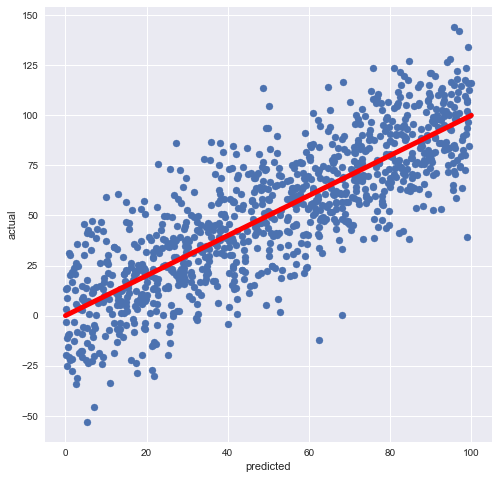

In [33]:
plt.figure(figsize  = (8,8))
plt.scatter(X, y)
plt.plot([0,100],[0,100], color = 'red', linewidth = 5)
plt.xlabel('predicted')
plt.ylabel('actual')

plt.savefig('charts/R2_Example.png', bbox_inches='tight')

plt.show()

In [32]:
y_avg = np.mean(y)
SStot = sum((y - y_avg)**2)
SSres = sum((y - X)**2)
print("SStot: %i" % SStot)
print("SSres: %i" % SSres)
print("R2: %.5f" % (1-SSres/SStot))

SStot: 1249503
SSres: 407976
R2: 0.67349


# Misconception 6 - Adjusted R Squared

## example 1

In [109]:
number_of_obs = 100
np.random.seed(my_seed)
X1 = np.random.uniform(0, 100, number_of_obs)
X2 = np.random.uniform(0, 100, number_of_obs)
residuals = np.random.normal(0, 1, number_of_obs)
y = 0.99 * X1 + 0.01 * X2 + residuals
X = np.vstack((X1, X2)).T
X1 = X1.reshape(-1,1)

In [110]:
lr = LinearRegression()
y_pred = lr.fit(X,y).predict(X)
R2 = r2_score(y, y_pred)
adj_R2 = 1 - ((1 - R2) * (number_of_obs - 1) / (number_of_obs - 2 - 1))
print("R2: %.5f" % R2)
print("Adjusted R2: %.5f" % adj_R2)

R2: 0.99871
Adjusted R2: 0.99868


In [111]:
lr = LinearRegression()
y_pred = lr.fit(X1,y).predict(X1)
R2 = r2_score(y, y_pred)
adj_R2 = 1 - ((1 - R2) * (number_of_obs - 1) / (number_of_obs - 1 - 1))
print("R2: %.5f" % R2)
print("Adjusted R2: %.5f" % adj_R2)

R2: 0.99865
Adjusted R2: 0.99863


does crossvalidation work? 

In [104]:
np.mean(cross_val_score(LinearRegression(), X, y, scoring = 'r2', cv=3))

0.4931076593855257

In [105]:
np.mean(cross_val_score(LinearRegression(), X1, y, scoring = 'r2', cv=3))

0.5303429449131565

## Example 2

In [150]:
number_of_obs = 1000
np.random.seed(my_seed)
X = np.random.uniform(0, 100, (number_of_obs,50))
residuals = np.random.normal(0, 20, number_of_obs)
y = np.sum(X, axis = 1) + residuals

In [151]:
lr = LinearRegression()
y_pred = lr.fit(X,y).predict(X)
R2 = r2_score(y, y_pred)
adj_R2 = 1 - ((1 - R2) * (number_of_obs - 1) / (number_of_obs - 10 - 1))
print("R2: %.5f" % R2)
print("Adjusted R2: %.5f" % adj_R2)

R2: 0.99116
Adjusted R2: 0.99107


In [152]:
X2 = X[:,:49]

In [153]:
lr = LinearRegression()
y_pred = lr.fit(X2,y).predict(X2)
R2 = r2_score(y, y_pred)
adj_R2 = 1 - ((1 - R2) * (number_of_obs - 1) / (number_of_obs - 9 - 1))
print("R2: %.5f" % R2)
print("Adjusted R2: %.5f" % adj_R2)

R2: 0.97385
Adjusted R2: 0.97361
